### Import libraries

In [1]:
# !pip install networkx
# !pip install tqdm

In [2]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Import data

The data consist of 4 columns: playerID (ID of the player), infect_status (whether the player is infected or not), lat (the latitude of the player's position), lon (the longitude of the player's position)

In [3]:
df = pd.read_csv("wow_data.csv")
df

,playerID,infect_status,lat,lon
0,1,0,3.438336,3.478929
1,2,1,20.100954,20.676184
2,3,0,3.922318,18.754120
3,4,0,19.198629,12.247341
4,5,0,16.020653,22.595396
5,6,0,9.803395,8.095101
6,7,0,3.666168,29.488902
7,8,1,5.058006,28.163640
8,9,1,18.028525,25.217665
9,10,0,8.968497,27.109549


### Data preprocessing

#### Generate the edge list from the distance between each node

In [4]:
# Get edgelist dictionary
graph_dict = {'source':[],'target':[],'weight':[]}

for i, row1 in df.iterrows():
    for j, row2 in df.iterrows():
        if i<j:
            # calculate the inverse distance of two players as the edge weight between two nodes 
            # (the closer the player, the higher the weight)
            inv_distance = 100/(((row1['lat']-row2['lat'])**2+(row1['lon']-row2['lon'])**2)**(0.5))
            graph_dict['source'].append(int(row1['playerID']))
            graph_dict['target'].append(int(row2['playerID']))
            graph_dict['weight'].append(inv_distance)

In [5]:
# Generate edgelist dataframe from dictionary
edges = pd.DataFrame.from_dict(graph_dict)

In [6]:
# Display edgelist in weight ascending order
edges.sort_values('weight',ascending=False).head()

,source,target,weight
178,7,27,311.811889
348,17,22,98.243624
45,2,19,91.006793
339,16,26,54.459368
159,7,8,52.033032


#### Generate networkx graph from edgelist

##### Initialise the graph

In [7]:
GOT = nx.from_pandas_edgelist(edges, 
                            source='source',
                            target='target',
                            edge_attr='weight' )

##### Get weighted degrees

In [8]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))

##### Train the best position to draw the graph nodes

In [9]:
pos = nx.spring_layout(GOT,weight='weight',iterations=50, k = 5)

##### Display networkx graph

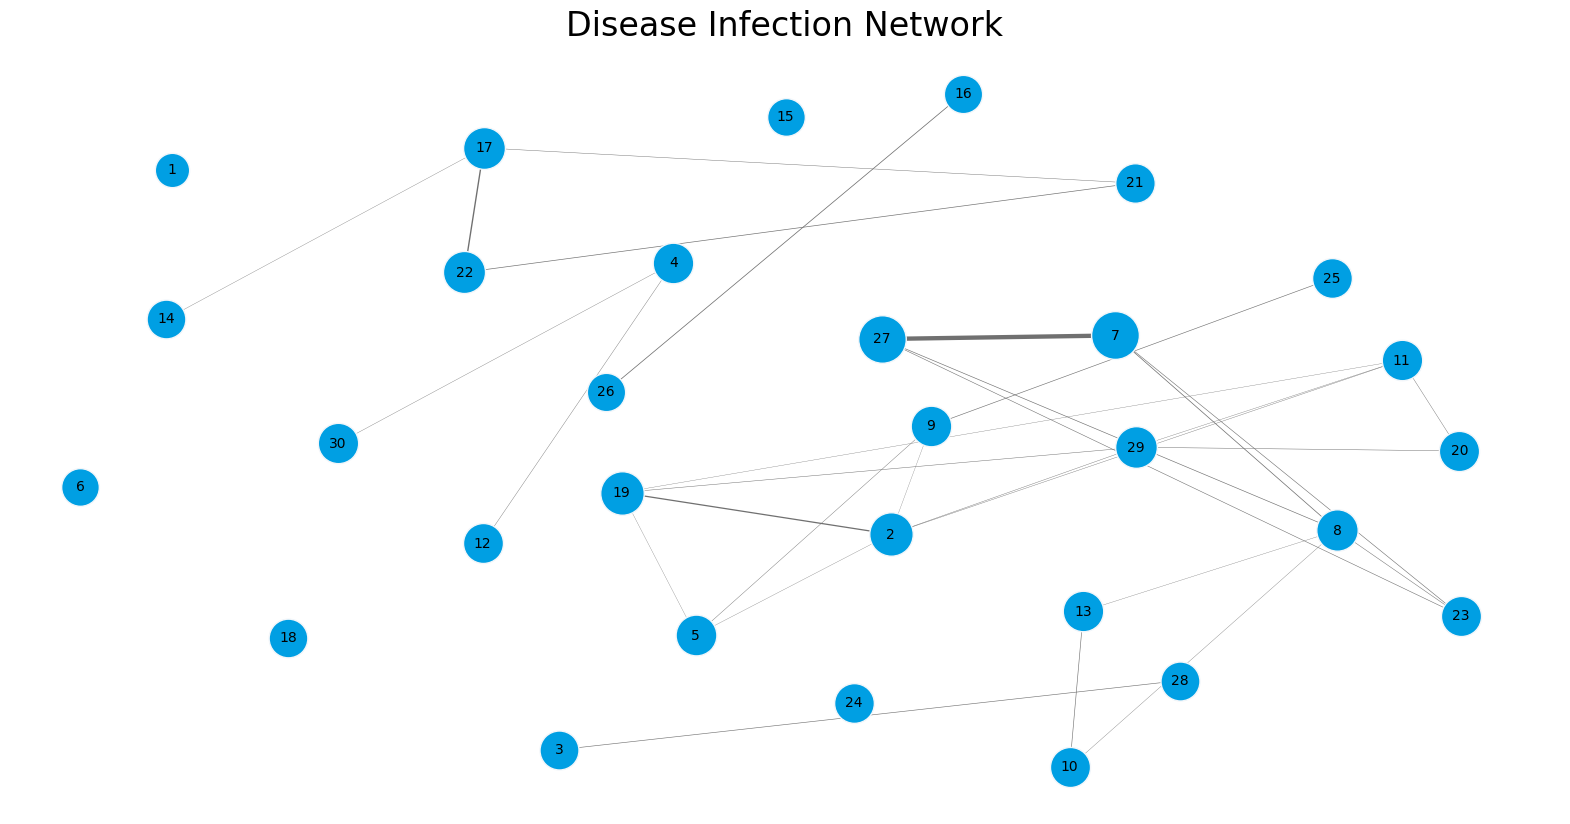

In [10]:
plt.axis('off')
plt.title('Disease Infection Network',fontsize = 24)

for node in GOT.nodes():
    size = 50*weighted_degrees[node]**0.5 # Hardcoded size for now, the normal size was too CHONK to display
    ns = nx.draw_networkx_nodes(GOT,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(GOT,pos,font_size=10);

for e in GOT.edges(data=True):
    # Only displaying edges with weight more than 20 (aka. the distance between players were less than 5 units)
    if e[2]['weight']>(100/5):         
        nx.draw_networkx_edges(GOT,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

Looking at the graph above, you can notice the clusters of nodes. 

The thickness of the edges depends on the weight of the edge, the higher the weight, the thicker the edge. This means that any two nodes that have a THICK edge between them will represent two players standing very close together.

You may also observe nodes that are not connected to any other nodes, this indicate players who social distance themselves. Nodes wi

#### Investigate the spread of disease over time

##### Our helper functions

In [11]:
# Function independent_cascade simulate the spread of disease in t->t+1 step
def independent_cascade(G,t,infection_times):
    min_weight = min([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times] # if infection_times[n]==t]
    # Each infectious node infects neigbors with probabilty proportional to the weight
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= ((100/5) + np.random.random()*min_weight): # 100/5 is the minimum weight to spread
                    infection_times[v] = t+1
    return infection_times

In [12]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Disease Infection Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 50*weighted_degrees[node]**0.5 # Hardcoded size for now, the normal size was too CHONK to display
        if node in current_infectious: # Currently being infected
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02') # yellow-ish
        elif infection_times.get(node,9999999)<t: # Infected 
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#fc896f') # red-ish
        else: # Healthy :)
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#38a874') # green-ish 
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,font_size=10);

    for e in G.edges(data=True):
        # Only displaying edges with weight more than 20 (aka. the distance between players were less than 5 units)
        if e[2]['weight']>(100/5):
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

##### Get the infected nodes

In [13]:
infection_times = {}

for i, row in df.iterrows():
    if row['infect_status']==1:
        infection_times[int(row['playerID'])] = -1
        
infection_times

{2: -1, 8: -1, 9: -1, 15: -1, 19: -1, 22: -1, 27: -1}

##### Run 10 iterations to investigate the spread of disease

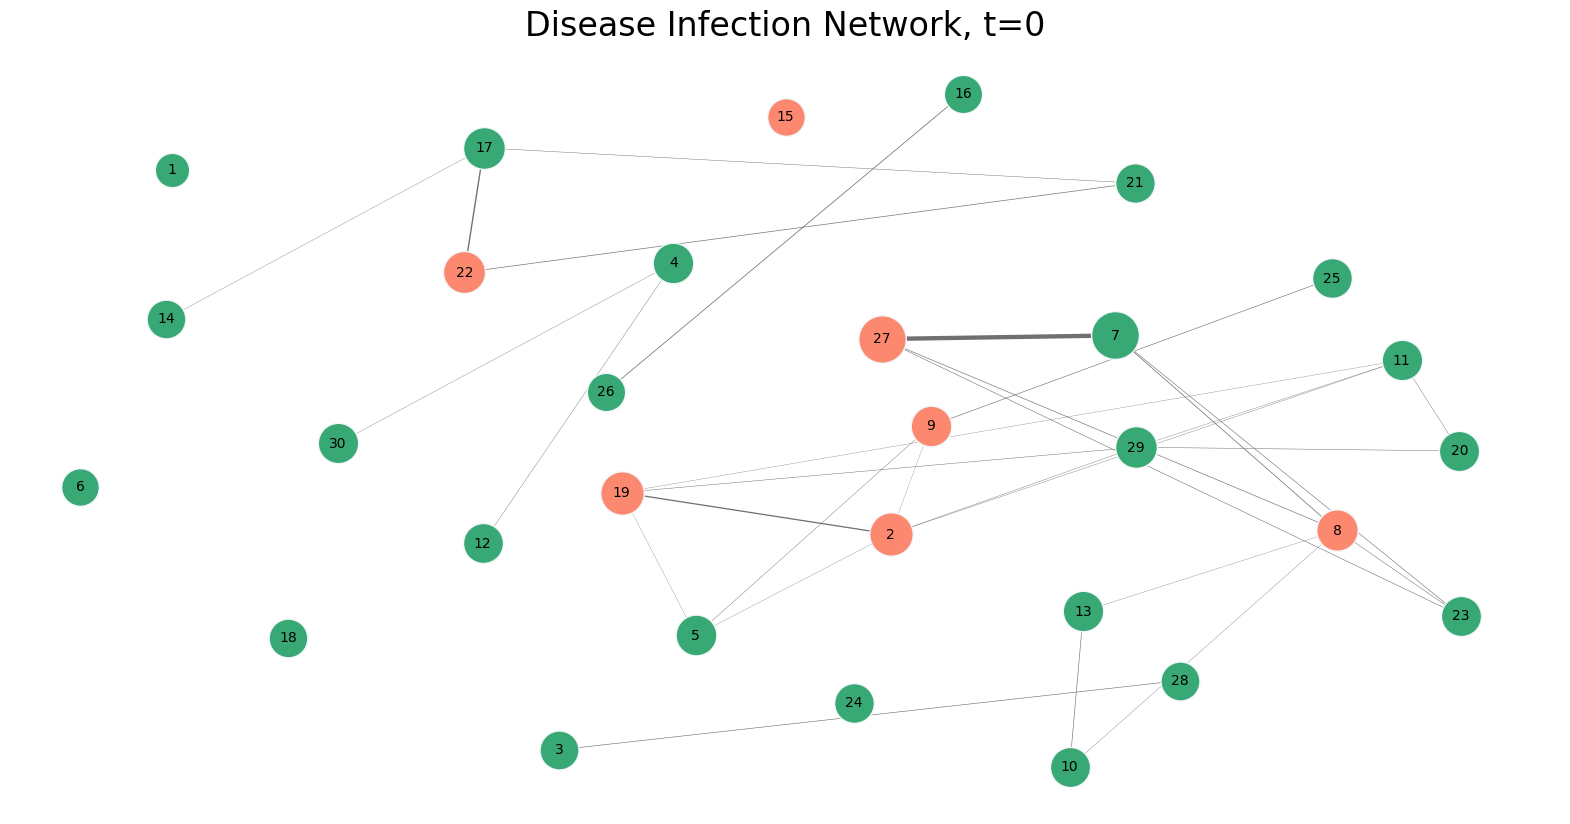

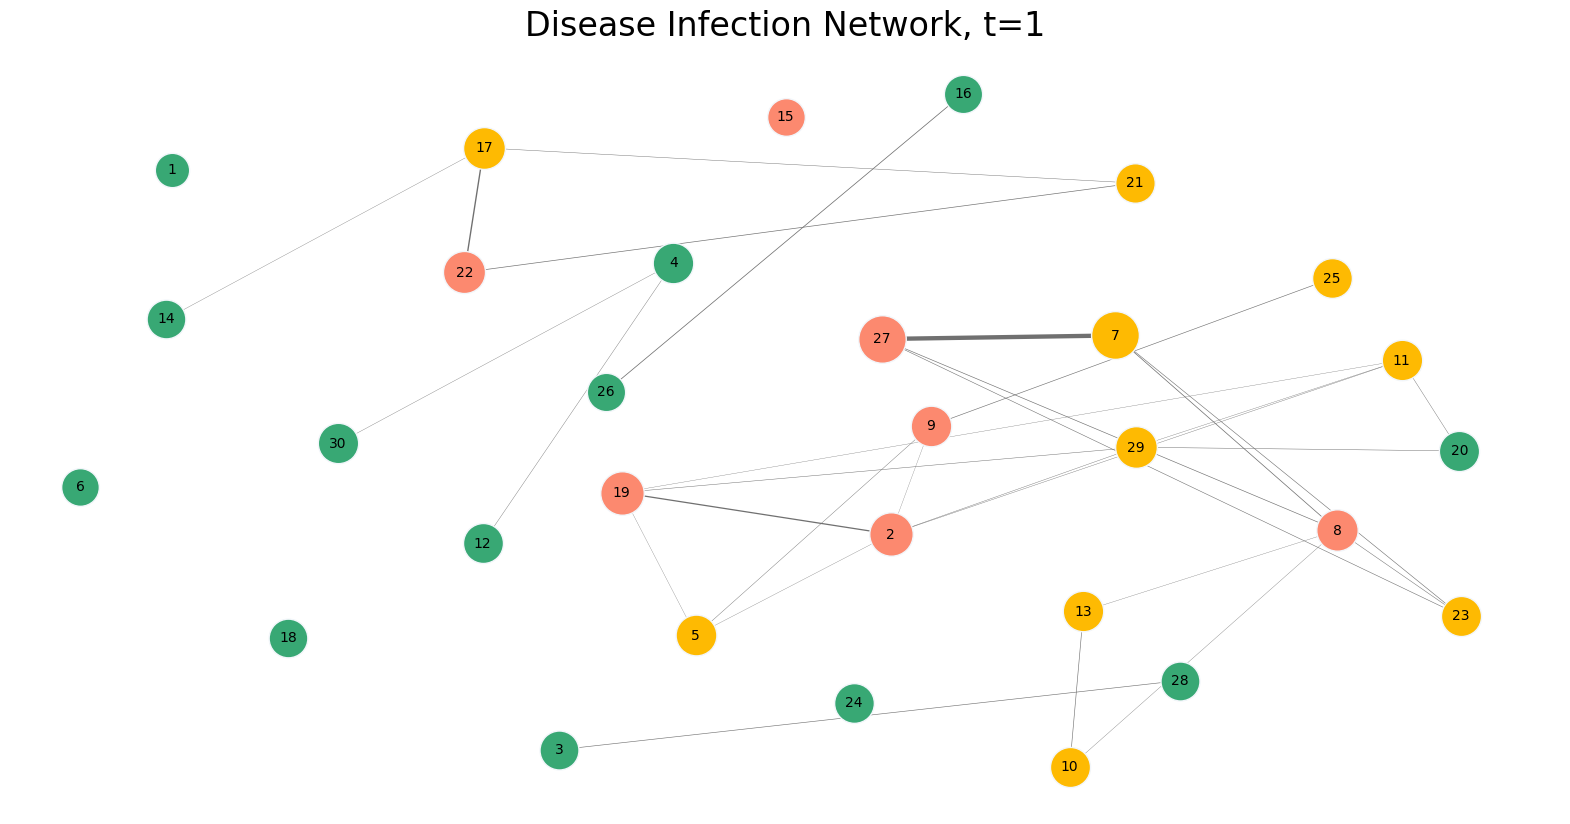

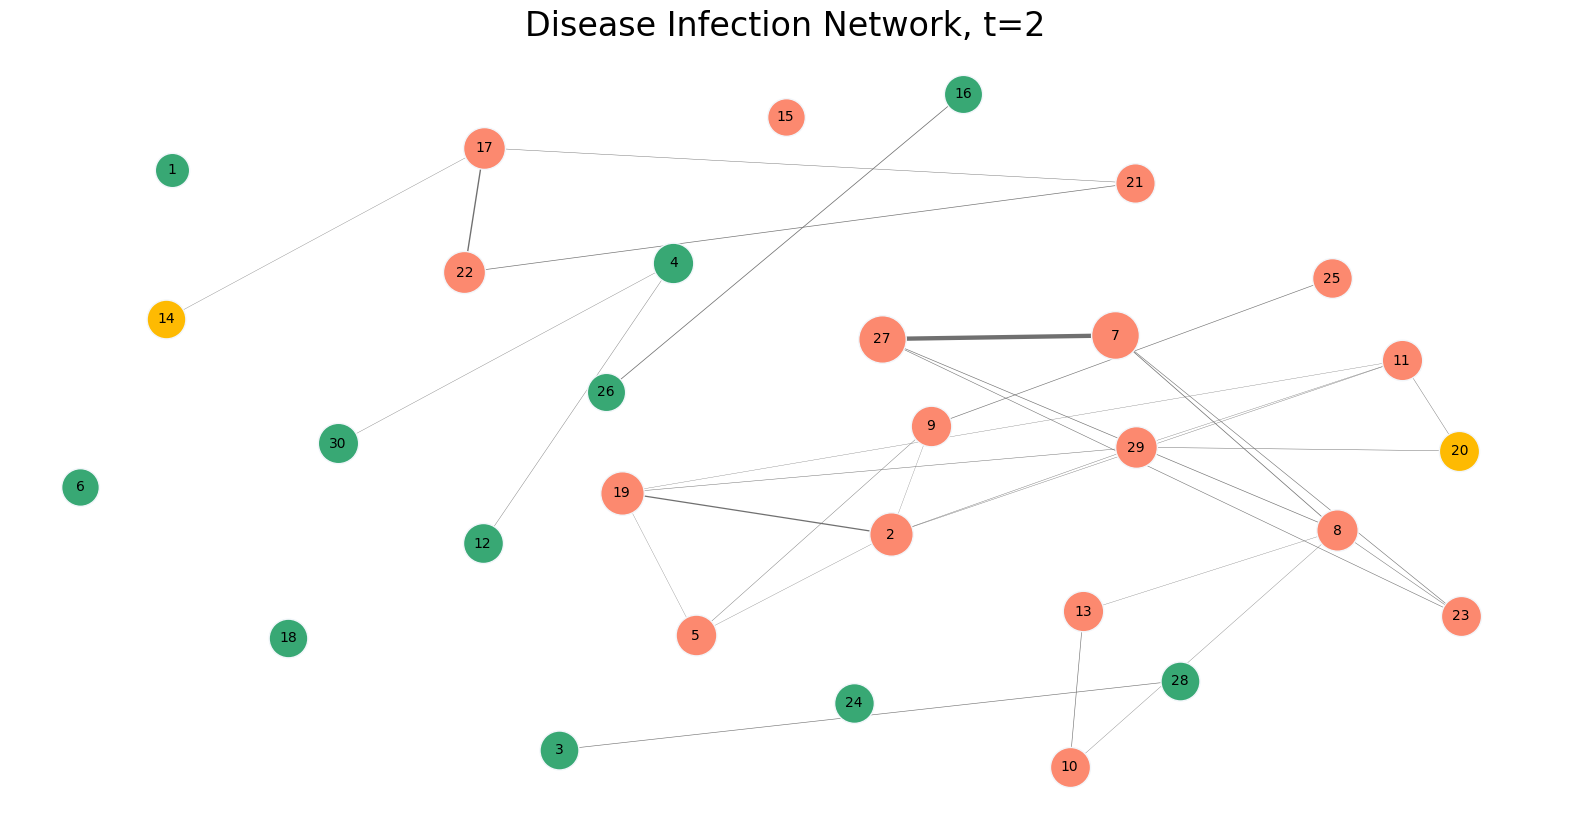

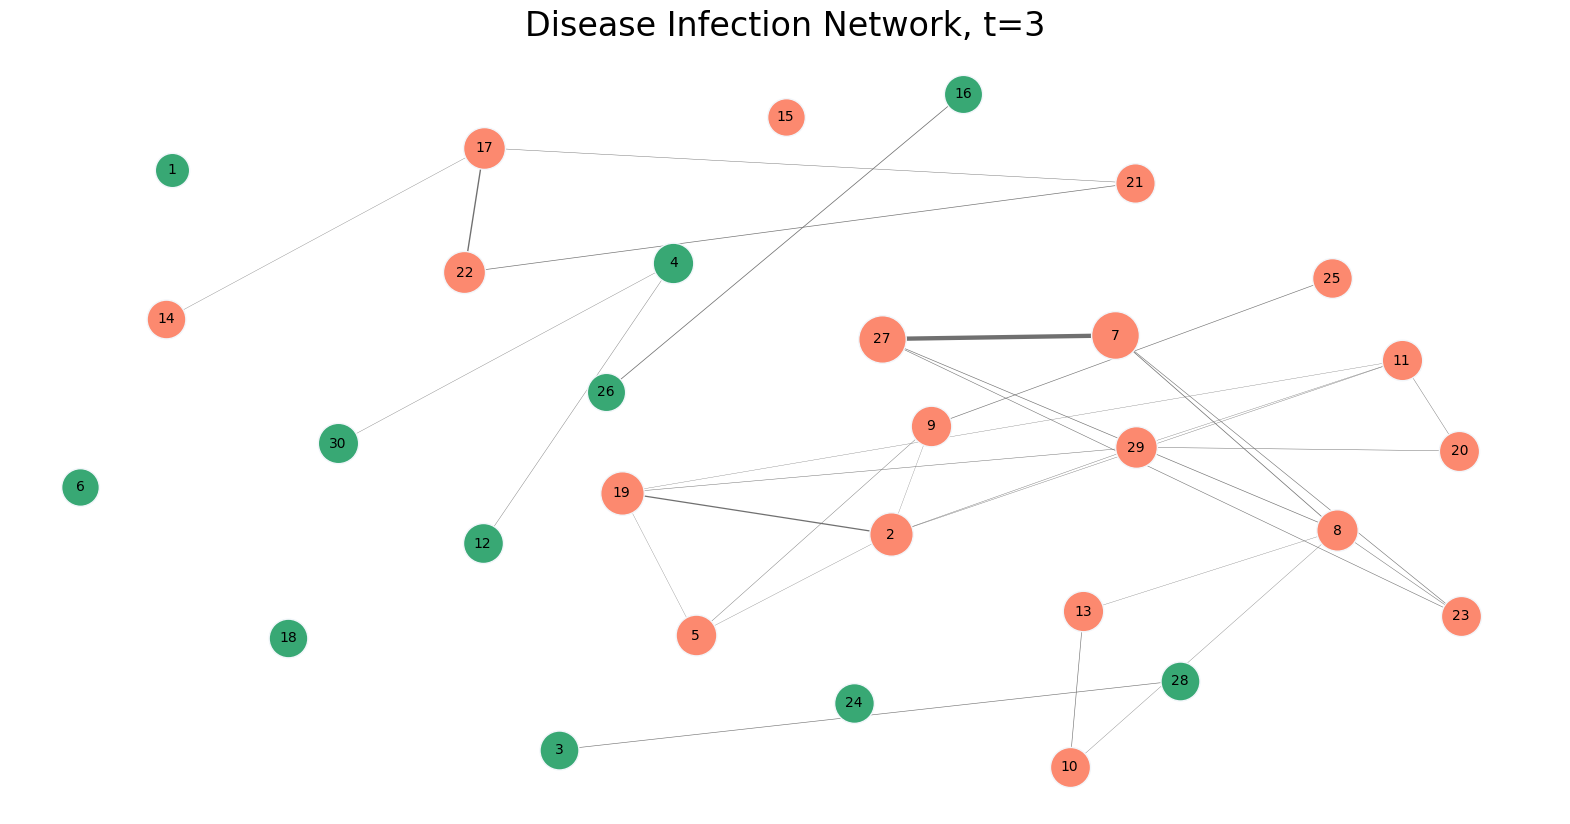

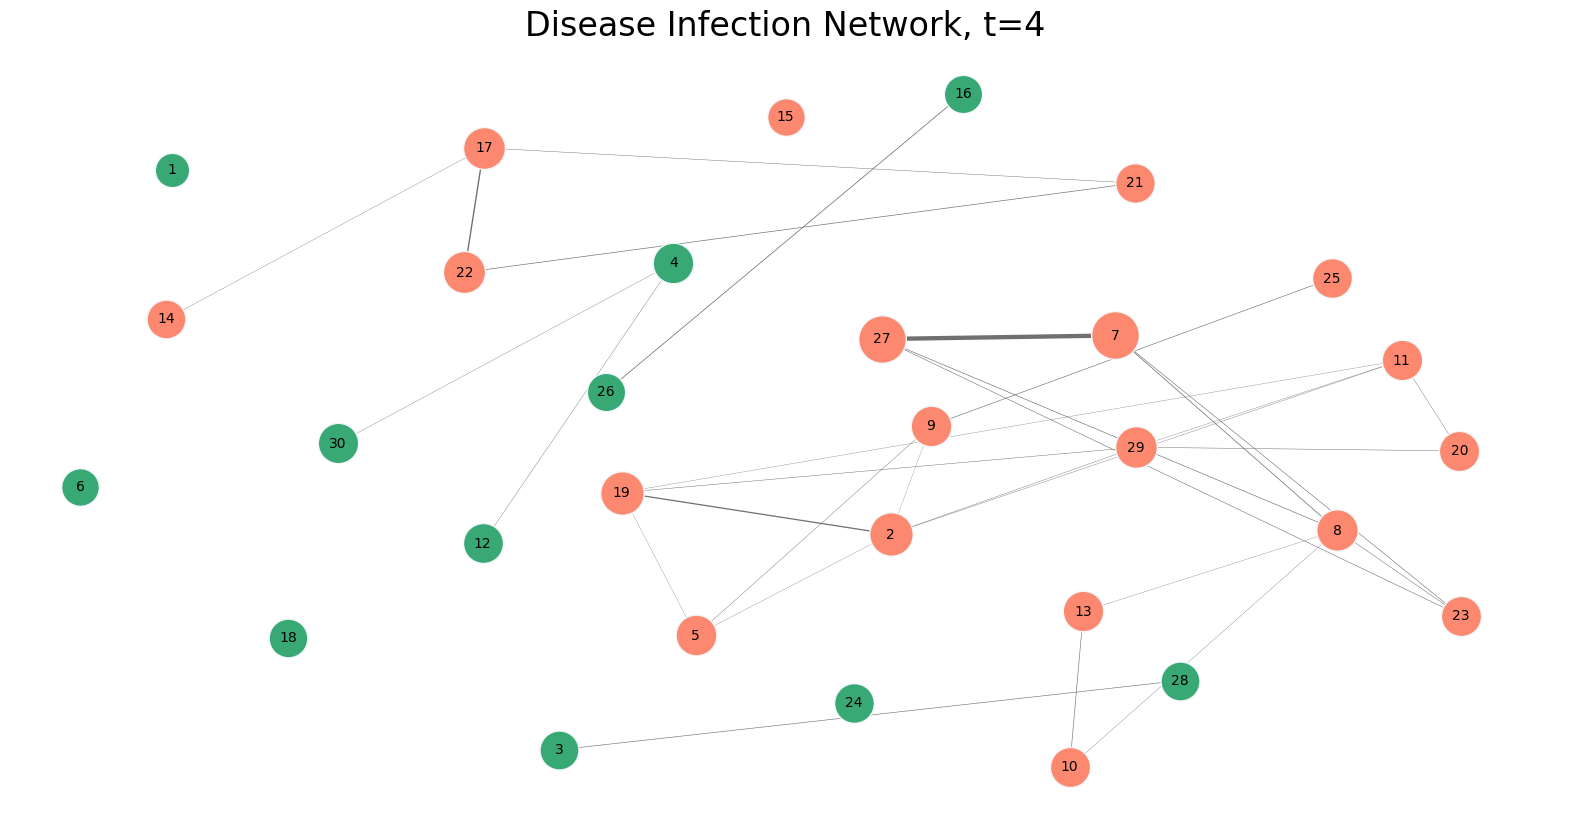

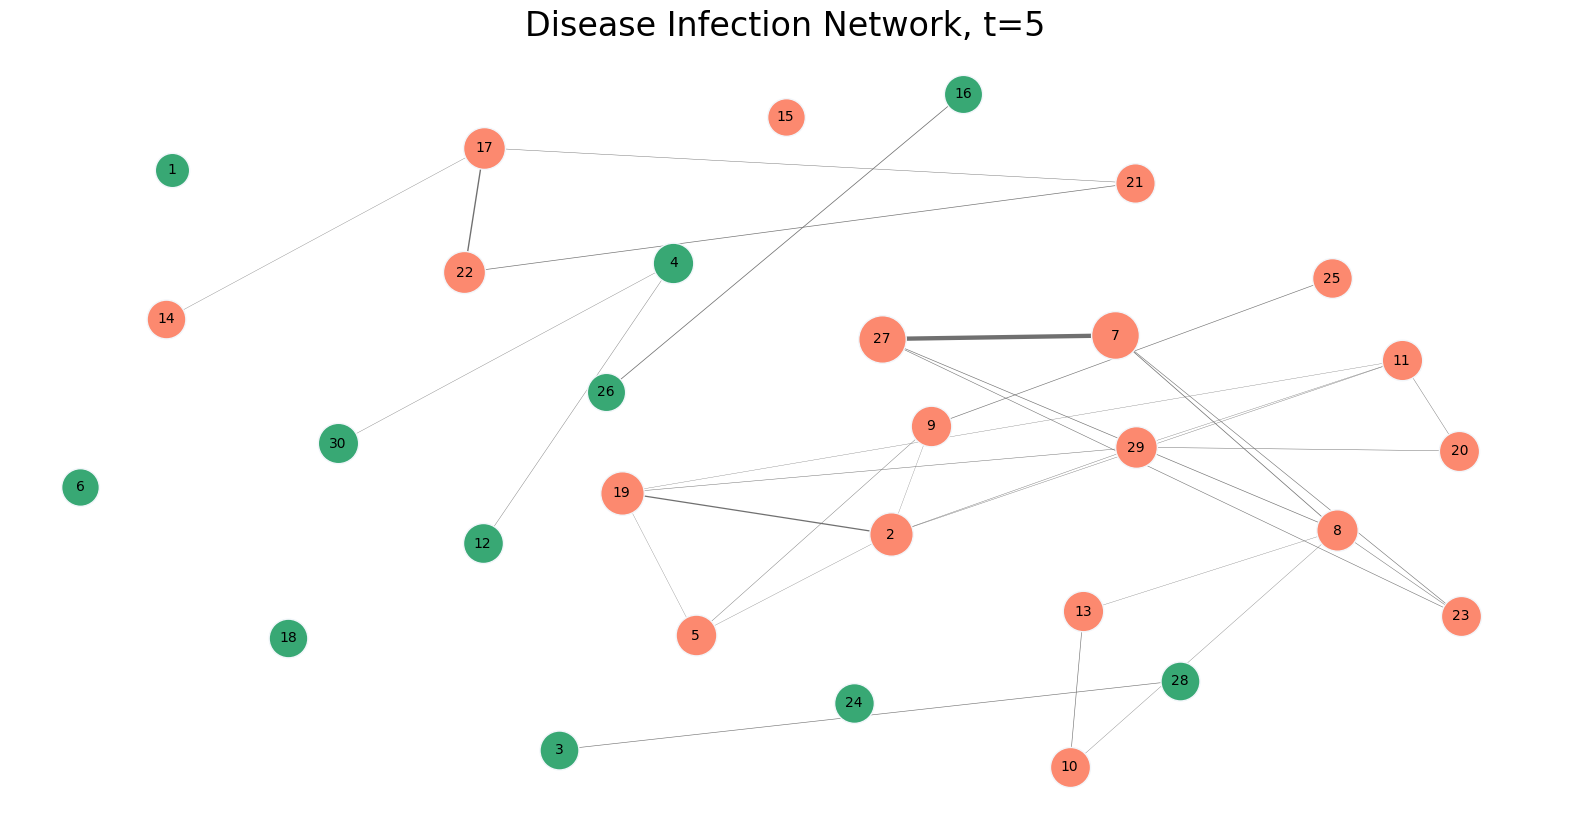

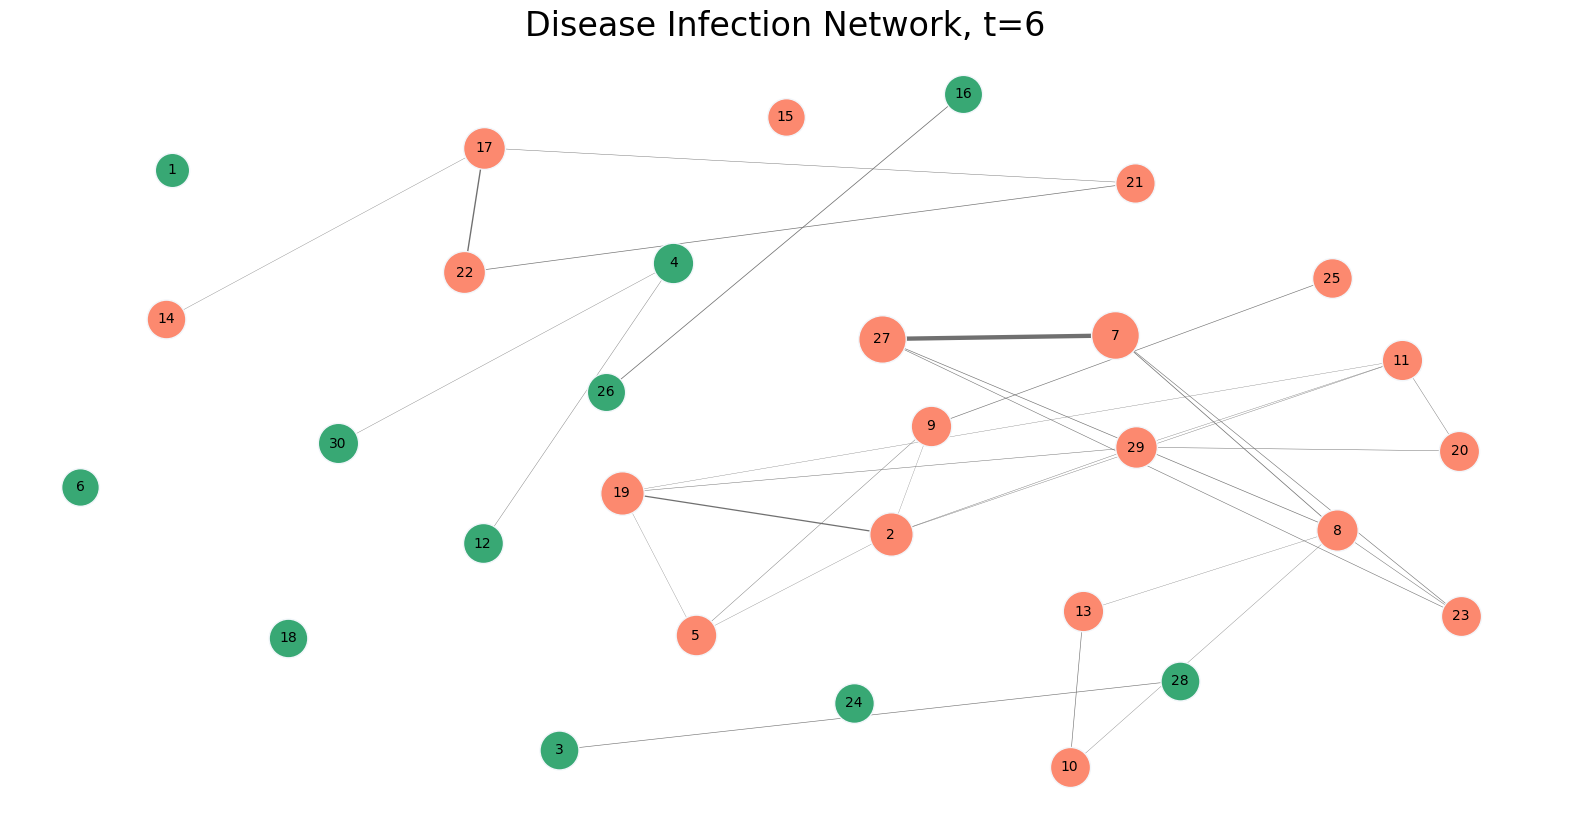

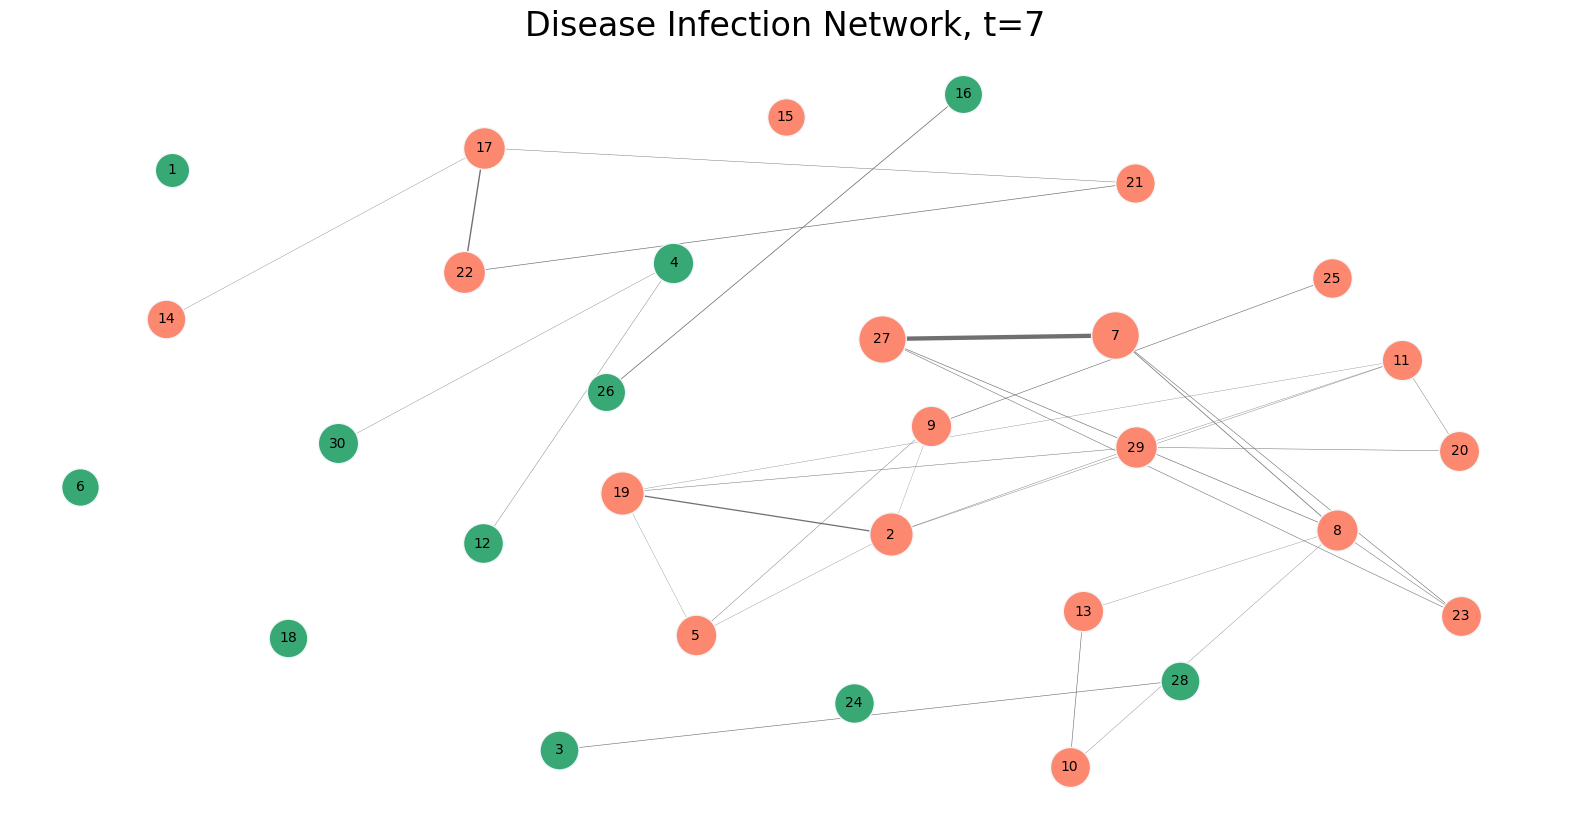

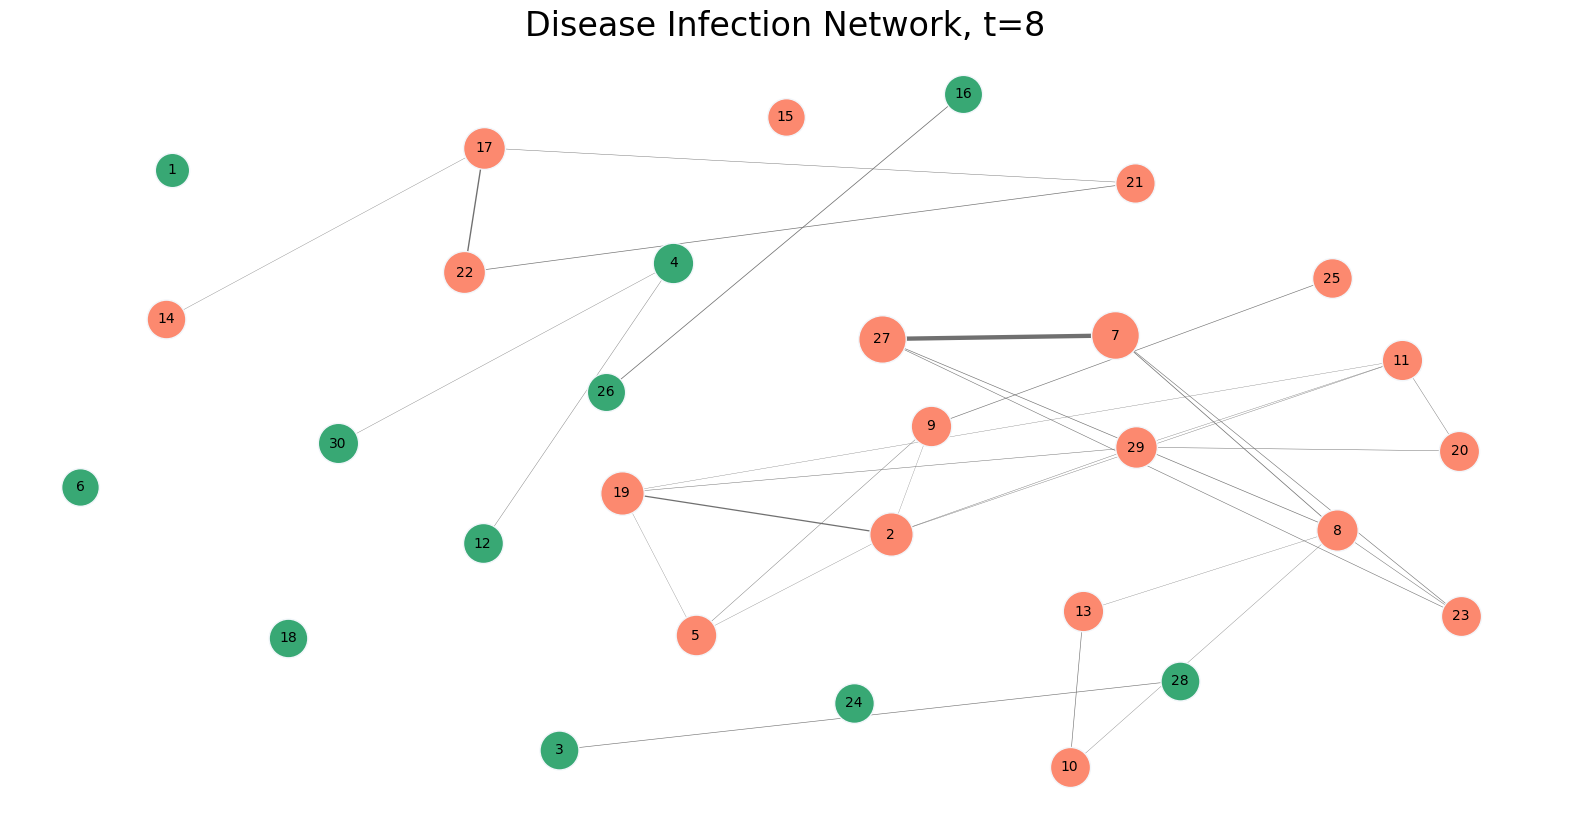

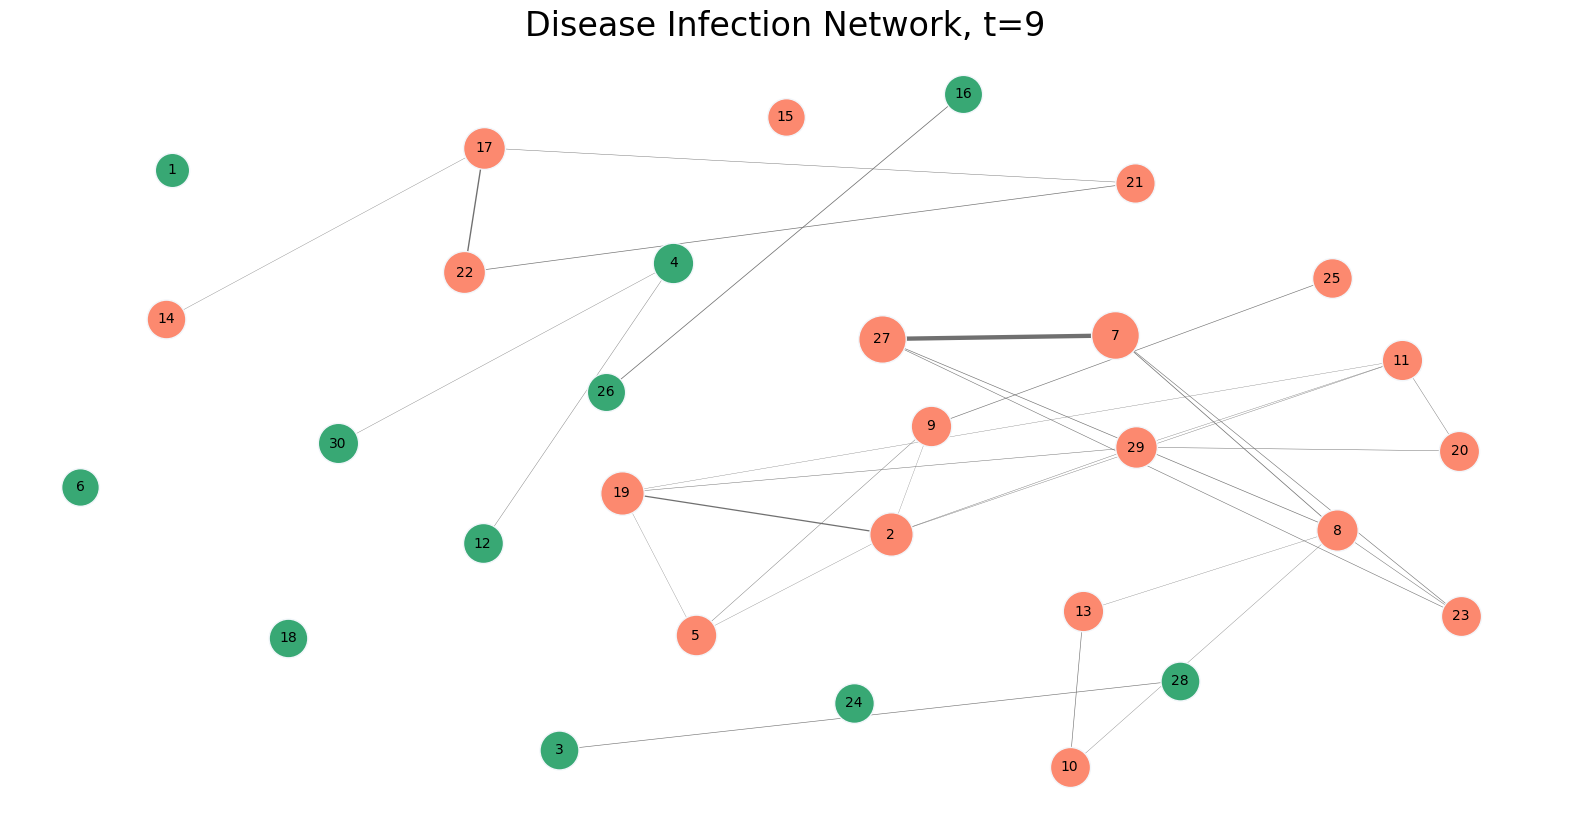

In [14]:
for t in range(10): # Run 10 iterations
    plot_G(GOT,pos,infection_times,t) # Plot current network
    infection_times = independent_cascade(GOT,t,infection_times) # Get new infection nodes